
MOTIVATION:
- Understand how well fitting works with a single feed fraction experiment. 

HYPOTHESIS:
- Low feed fractions will be difficult to fit. 


In [2]:
import numpy as np
from typing import Tuple

# import matplotlib

# matplotlib.use("webagg")
import matplotlib.pyplot as plt

from polypesto.models.equilibrium import EquilibriumRxn as Model
from polypesto.core.params import ParameterGroup
import polypesto.core.petab as pet
from polypesto.core.pypesto import create_problem_set, load_pypesto_problem
from polypesto.core.params import ParameterSet, ParameterGroup
from polypesto.utils.plot import plot_all_measurements

from pathlib import Path

import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
__file__ = "/PolyPESTO/experiments/equilibrium_rxn/single_rxn/analysis.ipynb"
DIR_NAME = os.path.basename(os.path.dirname(__file__))
DATA_DIR = os.path.join(os.path.dirname(__file__), "data")


# ************** Define parameters **************
def parameters() -> ParameterGroup:

    k1 = [0.1]
    k2 = [0.6]

    pg = ParameterGroup(DIR_NAME, {})
    for _k1 in k1:
        for _k2 in k2:
            pg.lazy_add({"k1": _k1, "k2": _k2})
    return pg


# ************** Define experiments **************
# experimental conditions, observables, and fit parameters
def experiment(t_eval, A, B) -> Tuple[str, pet.PetabData]:

    dir = os.path.join(DATA_DIR, f"A0_{A}_B0_{B}")

    # Define fitting parameters
    params_dict = Model.get_default_fit_params()
    param_df = pet.define_parameters(params_dict)

    # Define experimental conditions
    cond_df = Model.create_conditions(A, B)
    obs_df = Model.get_default_observables()
    empty_meas_df = pet.define_empty_measurements(obs_df, cond_df, t_eval)

    return dir, pet.PetabData(
        obs_df=obs_df, cond_df=cond_df, param_df=param_df, meas_df=empty_meas_df
    )


# ************** Define experiments **************
t_eval = np.arange(0, 1, 0.1, dtype=float)
As = np.array([[0.25, 0.5]])
Bs = np.array([[1.0, 1.0]])

for A, B in zip(As, Bs):

    # print(fA0, cM0)
    dir, data = experiment(t_eval, A, B)
    pg = parameters()
    print(pg)
    yaml_paths = create_problem_set(Model, parameters(), data, dir)
    # break

Visualization table not available. Skipping.
Visualization table not available. Skipping.


ParameterGroup(id='single_rxn', parameter_sets={'p_000': ParameterSet(id='p_000', parameters={'k1': Parameter(id='k1', value=0.1), 'k2': Parameter(id='k2', value=0.6)})})
Creating SBML model (equilibrium_rxn).
Creating reactions.
                 filename : /PolyPESTO/experiments/equilibrium_rxn/single_rxn/data/A0_[0.25 0.5 ]_B0_[1. 1.]/petab/common/equilibrium_rxn.xml
         file size (byte) : 2432
           read time (ms) : 1.922607
        c-check time (ms) : 0.593662
      validation error(s) : 0
    (consistency error(s)): 0
    validation warning(s) : 0
  (consistency warning(s)): 0
Simulating data for p_000...


Visualization table not available. Skipping.


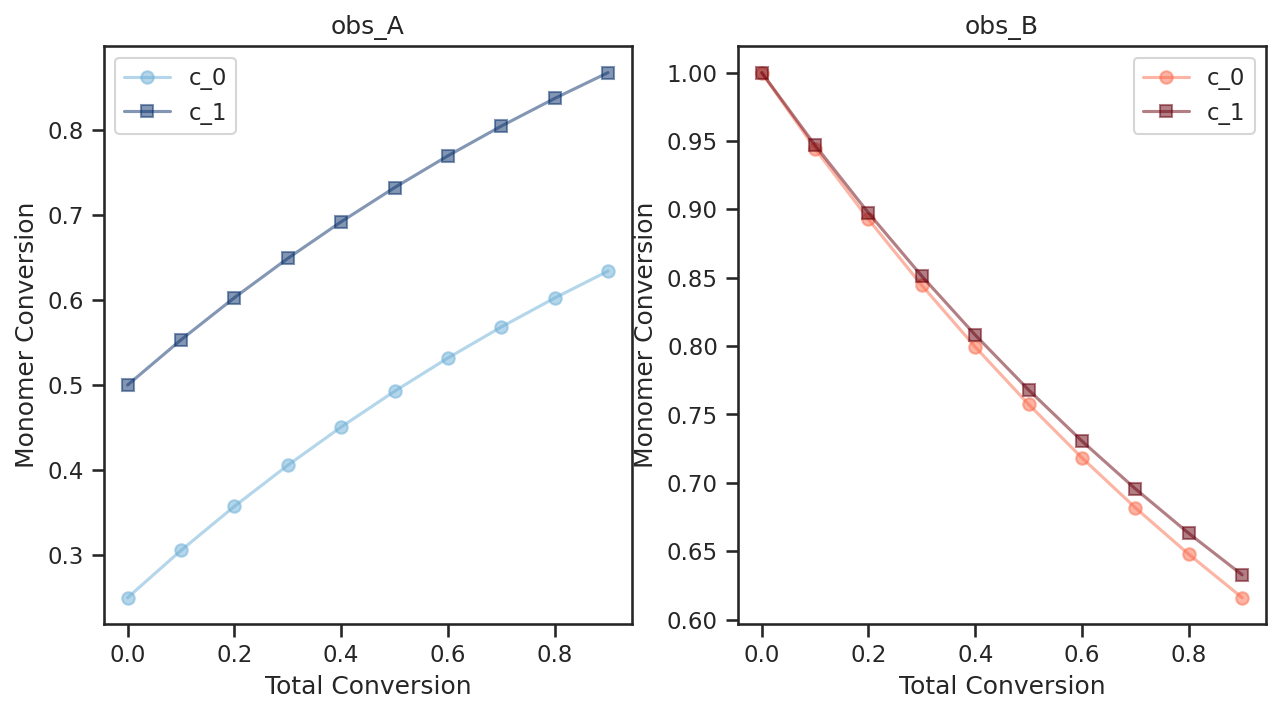

In [17]:
yaml_path = yaml_paths["p_000"]
importer, problem = load_pypesto_problem(yaml_path=yaml_path, model_name=Model.name)

plot_all_measurements(
    importer.petab_problem.measurement_df,
    # group_by=C.SIMULATION_CONDITION_ID,
    group_by=pet.C.OBSERVABLE_ID,
    format_axes_kwargs={
        "set_xlabel": "Total Conversion",
        "set_ylabel": "Monomer Conversion",
        # "set_xlim": (0, 1),
        # "set_ylim": (0, 1),
    },
    plot_style="both",
    alpha=0.5,
)
plt.show()

In [18]:
import pypesto
import pypesto.optimize as optimize
import pypesto.petab
import pypesto.sample as sample
import pypesto.visualize as visualize

optimizer = optimize.ScipyOptimizer()  # method="Nelder-Mead")  # method="Nelder-Mead")
# optimizer = optimize.PyswarmOptimizer()
history_options = pypesto.HistoryOptions(
    trace_record=True,  # storage_file="history_{id}.csv"
)
engine = pypesto.engine.MultiProcessEngine()
n_starts = 100

# run optimization of problem 1
import amici

# problem.startpoint_method = pypesto.startpoint.LatinHypercubeStartpoints()
# problem.objective.amici_solver.setSensitivityMethod(amici.SensitivityMethod.none)
# problem.objective.amici_solver.setSensitivityOrder(amici.SensitivityOrder.first)
problem.objective.amici_solver.setMaxStepSize(1e-3)
# problem.objective.amici_model.setAlwaysCheckFinite(True)
# problem.objective.amici_solver.setSensitivityOrder(1)
# problem.objective.amici_solver.
# problem.objective.amici_solver.setSensitivityOrder(amici.SensitivityOrder.first)
optimizer = optimize.ScipyOptimizer()  # method="Nelder-Mead")  # method="Nelder-Mead")
history_options = pypesto.HistoryOptions(
    trace_record=True,  # storage_file="history_{id}.csv"
)
engine = pypesto.engine.MultiProcessEngine()
n_starts = 100

problem.objective.amici_solver.setMaxStepSize(1e-3)
result = optimize.minimize(
    problem=problem,
    optimizer=optimizer,
    n_starts=n_starts,
    engine=engine,
    history_options=history_options,
)

Engine will use up to 8 processes (= CPU count).
Engine will use up to 8 processes (= CPU count).
100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.19it/s]


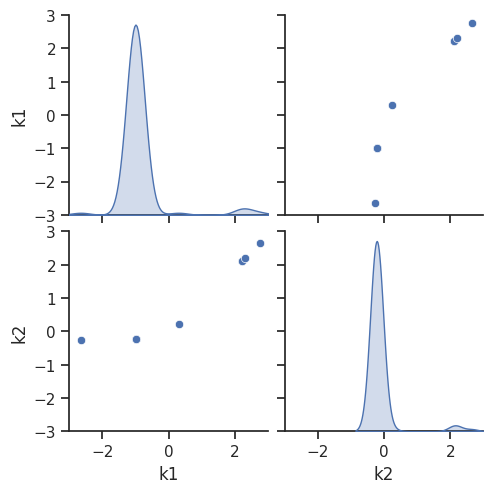

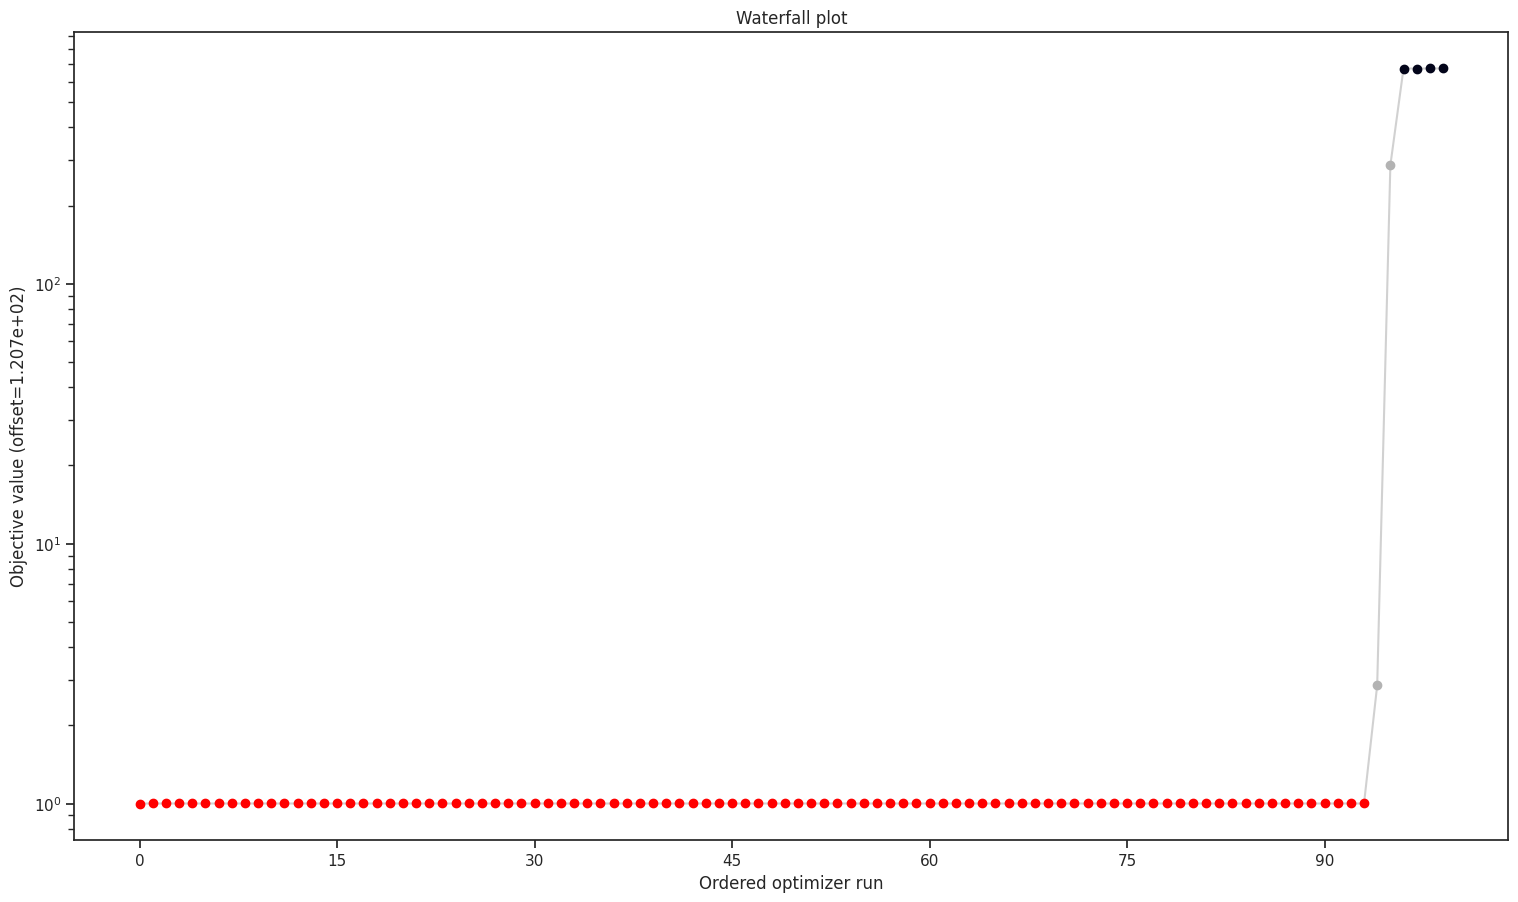

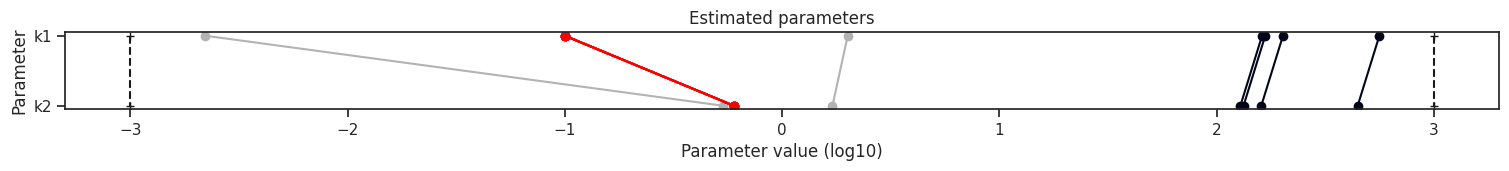

In [19]:
ax = visualize.optimization_scatter(result=result, show_bounds=True)
ax = visualize.waterfall(result)
ax = visualize.parameters(result)

In [20]:
sampler = sample.AdaptiveParallelTemperingSampler(
    internal_sampler=sample.AdaptiveMetropolisSampler(),
    n_chains=3,
    # betas=[1, 0.5, 0.1, 0.05],
    # options=dict(max_temp=10),
)
# sampler = sample.AdaptiveMetropolisSampler()
# sampler = sample.MetropolisSampler()
# problem.objective.amici_solver.setMaxStepSize(1e-3)
n_samples = 10000
result = sample.sample(
    problem,
    n_samples=n_samples,
    sampler=sampler,
    # x0=result.optimize_result.list[0]["x"][0:2],
    # x0=np.array([0, 0]),
    filename=None,
    result=result,
)
elapsed_time = result.sample_result.time
print(f"Elapsed time: {round(elapsed_time,2)}")

Initializing betas with "near-exponential decay".
100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 506.82it/s]
Elapsed time: 19.765448389


Elapsed time: 19.77


/usr/local/lib/python3.10/dist-packages/pypesto/visualize/sampling.py:1117: UserWarning: Burn in index not found in the results, the full chain will be shown.
You may want to use, e.g., `pypesto.sample.geweke_test`.
  nr_params, params_fval, theta_lb, theta_ub, param_names = get_data_to_plot(
/usr/local/lib/python3.10/dist-packages/pypesto/visualize/sampling.py:79: UserWarning: Burn in index not found in the results, the full chain will be shown.
You may want to use, e.g., `pypesto.sample.geweke_test`.
  _, params_fval, _, _, _ = get_data_to_plot(


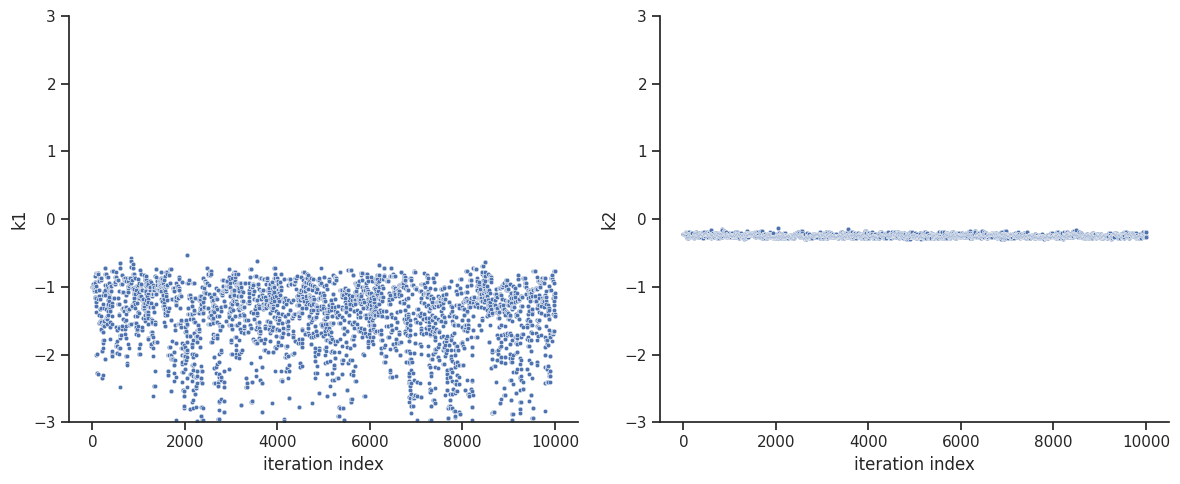

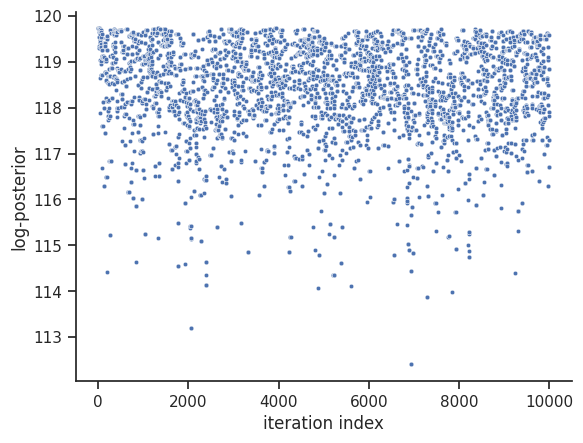

In [21]:
ax = visualize.sampling_parameter_traces(result, use_problem_bounds=True, size=(12, 5))
ax = visualize.sampling_fval_traces(result)

/usr/local/lib/python3.10/dist-packages/pypesto/visualize/sampling.py:1117: UserWarning: Burn in index not found in the results, the full chain will be shown.
You may want to use, e.g., `pypesto.sample.geweke_test`.
  nr_params, params_fval, theta_lb, theta_ub, param_names = get_data_to_plot(
/usr/local/lib/python3.10/dist-packages/pypesto/visualize/sampling.py:79: UserWarning: Burn in index not found in the results, the full chain will be shown.
You may want to use, e.g., `pypesto.sample.geweke_test`.
  _, params_fval, _, _, _ = get_data_to_plot(


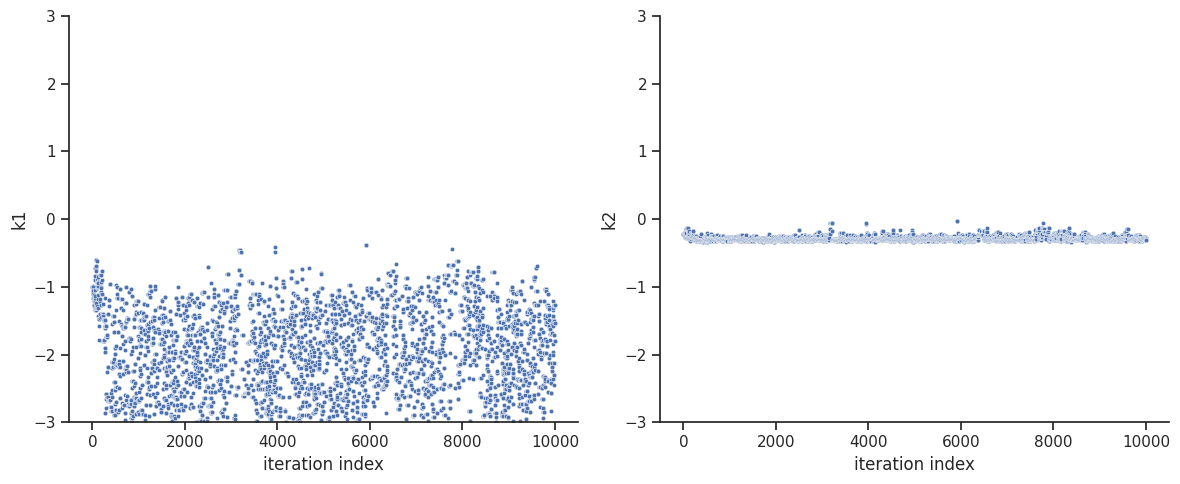

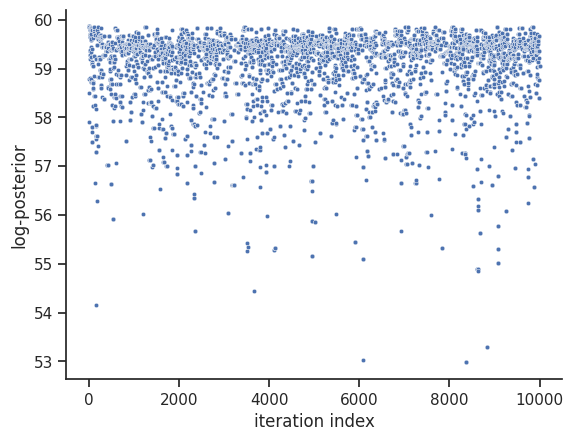

In [9]:
ax = visualize.sampling_parameter_traces(result, use_problem_bounds=True, size=(12, 5))
ax = visualize.sampling_fval_traces(result)

In [ ]:
from pypesto.C import AMICI_STATUS, AMICI_T, AMICI_X, AMICI_Y
from pypesto.predict import AmiciPredictor


# This post_processor will transform the output of the simulation tool
# such that the output is compatible with the next steps.
def post_processor(amici_outputs, output_type, output_ids):
    outputs = [
        (
            amici_output[output_type]
            if amici_output[AMICI_STATUS] == 0
            else np.full((len(amici_output[AMICI_T]), len(output_ids)), np.nan)
        )
        for amici_output in amici_outputs
    ]
    return outputs


# Setup post-processors for both states and observables.
from functools import partial

amici_objective = result.problem.objective
state_ids = amici_objective.amici_model.getStateIds()
observable_ids = amici_objective.amici_model.getObservableIds()
post_processor_x = partial(
    post_processor,
    output_type=AMICI_X,
    output_ids=state_ids,
)
post_processor_y = partial(
    post_processor,
    output_type=AMICI_Y,
    output_ids=observable_ids,
)

# Create pyPESTO predictors for states and observables
predictor_x = AmiciPredictor(
    amici_objective,
    post_processor=post_processor_x,
    output_ids=state_ids,
)
predictor_y = AmiciPredictor(
    amici_objective,
    post_processor=post_processor_y,
    output_ids=observable_ids,
)

from pypesto.C import EnsembleType
from pypesto.ensemble import Ensemble

# corresponds to only the estimated parameters
x_names = result.problem.get_reduced_vector(result.problem.x_names)

# Create the ensemble with the MCMC chain from parallel tempering with the real temperature.
ensemble = Ensemble.from_sample(
    result,
    chain_slice=slice(
        None, None, 5
    ),  # Optional argument: only use every fifth vector in the chain.
    x_names=x_names,
    ensemble_type=EnsembleType.sample,
    lower_bound=result.problem.lb,
    upper_bound=result.problem.ub,
)

In [ ]:
result.sample_result.betas

In [ ]:
for i_chain in range(len(result.sample_result.betas)):
    visualize.sampling_1d_marginals(
        result,
        i_chain=i_chain,
        suptitle=f"Chain: {i_chain}",
    )

In [ ]:
from pypesto.engine import MultiProcessEngine

engine = MultiProcessEngine()

ensemble_prediction = ensemble.predict(
    predictor_x, prediction_id=AMICI_X, engine=engine
)
from pypesto.C import CONDITION, OUTPUT

credibility_interval_levels = [90, 95, 99]

ax = visualize.sampling_prediction_trajectories(
    ensemble_prediction,
    levels=credibility_interval_levels,
    size=(10, 5),
    # labels={"A": "state_A", "condition_0": "cond_0"},
    axis_label_padding=60,
    groupby=CONDITION,
    # condition_ids=["condition_0", "condition_1", "condition_2"],  # `None` for all conditions
    # output_ids=["A", "B"],  # `None` for all outputs
)

In [ ]:
petab_problem = importer.petab_problem

In [ ]:
def show_measurement_fit(petab_problem, engine):

    mdf = petab_problem.measurement_df
    # Create a custom objective with new output timepoints.
    conditions = mdf[pet.C.SIMULATION_CONDITION_ID].unique()
    timepoints = [
        mdf[mdf[pet.C.SIMULATION_CONDITION_ID] == c][pet.C.TIME].unique()
        for c in conditions
    ]
    amici_objective_custom = amici_objective.set_custom_timepoints(
        timepoints=timepoints
    )

    # Create an observable predictor with the custom objective.
    predictor_y_custom = AmiciPredictor(
        amici_objective_custom,
        post_processor=post_processor_y,
        output_ids=observable_ids,
        condition_ids=[edata.id for edata in amici_objective_custom.edatas],
    )

    # Predict then plot.
    ensemble_prediction = ensemble.predict(
        predictor_y_custom, prediction_id=AMICI_Y, engine=engine
    )

    ax = visualize.sampling_prediction_trajectories(
        ensemble_prediction,
        levels=credibility_interval_levels,
        groupby=CONDITION,
        # measurement_df=mdf,
        size=(12, 6),
    )

    return ax


# import matplotlib.pyplot as plt
# ax[0][0].set_title('')
# ax[1][0].set_title('')
# ax[0][1].set_title('')
# # ax[1][1].set_title('')
# ax[0][0].set_ylim([-0.1, 2.1])
# ax[1][0].set_ylim([-0.1, 2.1])
# ax[0][1].set_ylim([-0.1, 2.1])
# ax[1][1].set_ylim([-0.1, 2.1])

ax = show_measurement_fit(petab_problem, engine)
plt.tight_layout()
fig = ax[0][0].get_figure()
fig.savefig("FRP2_measurement_fit.png")
plt.show()

In [ ]:
def visualize_sampling_results(result, petab_problem, engine=None):
    """
    Visualize how sampled parameters predict the data with credibility intervals.

    Parameters:
    -----------
    result : pypesto.Result
        PyPESTO result object containing sampling results
    petab_problem : petab.Problem
        PEtab problem definition
    engine : pypesto.Engine, optional
        Engine for parallel computation

    Returns:
    --------
    ax : matplotlib.axes
        The axes with the plotted results
    """
    # Create an ensemble from the sampling results
    # Skip burn-in period (first 20% of samples)
    samples = result.sample_result.trace_x[0]
    burnin = int(len(samples) * 0.2)
    samples_subset = samples[burnin::10]  # Take every 10th sample to reduce computation
    print(samples_subset)

    # Create the ensemble
    ensemble = pypesto.ensemble.Ensemble(samples_subset)
    print(ensemble)
    # Get measurement data frame
    mdf = petab_problem.measurement_df

    # Extract unique conditions and timepoints
    conditions = mdf[pet.C.SIMULATION_CONDITION_ID].unique()
    timepoints = [
        mdf[mdf[pet.C.SIMULATION_CONDITION_ID] == c][pet.C.TIME].unique()
        for c in conditions
    ]
    print(timepoints)
    # Create custom objective with these timepoints
    amici_objective_custom = result.problem.objective.set_custom_timepoints(
        timepoints=timepoints
    )

    # Define the observable IDs (based on your model)
    observable_ids = petab_problem.observable_df.index.tolist()

    # Create predictor with the custom objective
    predictor_y_custom = pypesto.predict.AmiciPredictor(
        amici_objective_custom,
        # Use appropriate post-processor for your model
        condition_ids=[edata.id for edata in amici_objective_custom.edatas],
        output_ids=observable_ids,
    )

    # Define credibility interval levels
    credibility_interval_levels = [0.5, 0.95]  # 50% and 95% CI

    # Predict then plot
    ensemble_prediction = ensemble.predict(
        predictor_y_custom,  # prediction_id="y_model", engine=engine
    )

    # Create visualizations
    ax = pypesto.visualize.sampling_prediction_trajectories(
        ensemble_prediction,
        levels=credibility_interval_levels,
        groupby="condition",
        measurement_df=mdf,  # Include measurements
        size=(12, 6),
    )

    # Customize the plot if needed
    for row in ax:
        for subplot in row:
            subplot.set_ylim([-0.1, 2.1])  # Adjust based on your data range

    plt.tight_layout()
    return ax


petab_problem = importer.petab_problem
visualize_sampling_results(result, petab_problem)

In [ ]:
samples = result.sample_result.trace_x[0]
samples[10::10]